# Housing Median Value Prediction

In this notebook we will study the problem of house pricing prediction. We will use
the California Housing Prices dataset from the StatLib repository. This dataset is based
on data from the 1997 California Census. Several values are outdated, but still reflects
trends on housing pricing on the Bay Area y Los Angeles metro area.

This study is included on Chapter 2 of the book Hands-On Machine Learning with Scikit-Learn,
Keras and TensorFlow, 2nd Edition. I'm adding my own code modifications and other
clarifications to this study in my own words, also there are sections that are intentionally
longer to check for other alternatives or present details not explained on the book.

### Business Requirements
First we need to understand the business requirements (one, or many) that we could face in this
kind of study. We need to be able to predict a house/apartment unit price depending on one
or several characteristics (features) of the house.

The value proposition of this requirement is to be able to predict/estimate the price that a
house should have depending on the characteristics of the property unit. This is helpful in
case we need to price a house for selling (to prevent underpricing) or to do an assessment if
a house is undervalued or overvalued in a particular neighbourhood. This is critical if you
intend to invest on real estate, and you want to get the highest return on your investment.

### Machine Learning Problem Type

After understanding the business requirement(s), we need to classify this problem to select
a type of machine learning algorithm to apply:
- **Supervised Learning:** we have a dataset for training. We have features like bedrooms, bathrooms,
population, median income, and also the label or output, the **median house value**.
- **Batch Learning:** there is no stream of continuous data to analyze, so we'll execute offline
training.
- **Regression Task:** we need to predict a value, so we can adjust a polynomial or linear
function to the dataset and then use that function to predict a house value with some inputs.
- **Multiple Regression:** we use multiple features (variables) to predict a value.
- **Univariate Regression Problem:** we need to predict only one value, the house price.

With this information we can narrow the possible candidate techniques or algorithms used to solve
this problem, but first we need to inspect, organize and clean our training data.

### Fetch the data
We use Python's `urllib` module to download the dataset from github.com, to prevent
overloading github servers, then check if the file exists and download only if the
dataset is missing.
We define a function `fetch_housing_data` to download the dataset, and then we invoke
it to extract the CSV dataset file into the `datasets` directory.

In [1]:
import os
import tarfile
from urllib.request import urlretrieve

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join('../datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    if os.path.exists(tgz_path):
        return
    urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

### Load CSV contents into a Pandas Dataframe
Using pandas, we load the entire dataset into memory, this dataset is small (aprox.
20000 values).

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

### Inspect the dataset
Let's inspect the dataset to have an idea of the values that contains and
potential problems like null/missing values and also to check continuous vs categorical data.

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


By looking at the dataset info, we can see that `total_bedrooms` column has missing
values, we need to watch-out for that.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Also we can see that `ocean_proximity` column contains categorical values. With
`value_counts()` function we can show a distinct grouping for that feature.

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


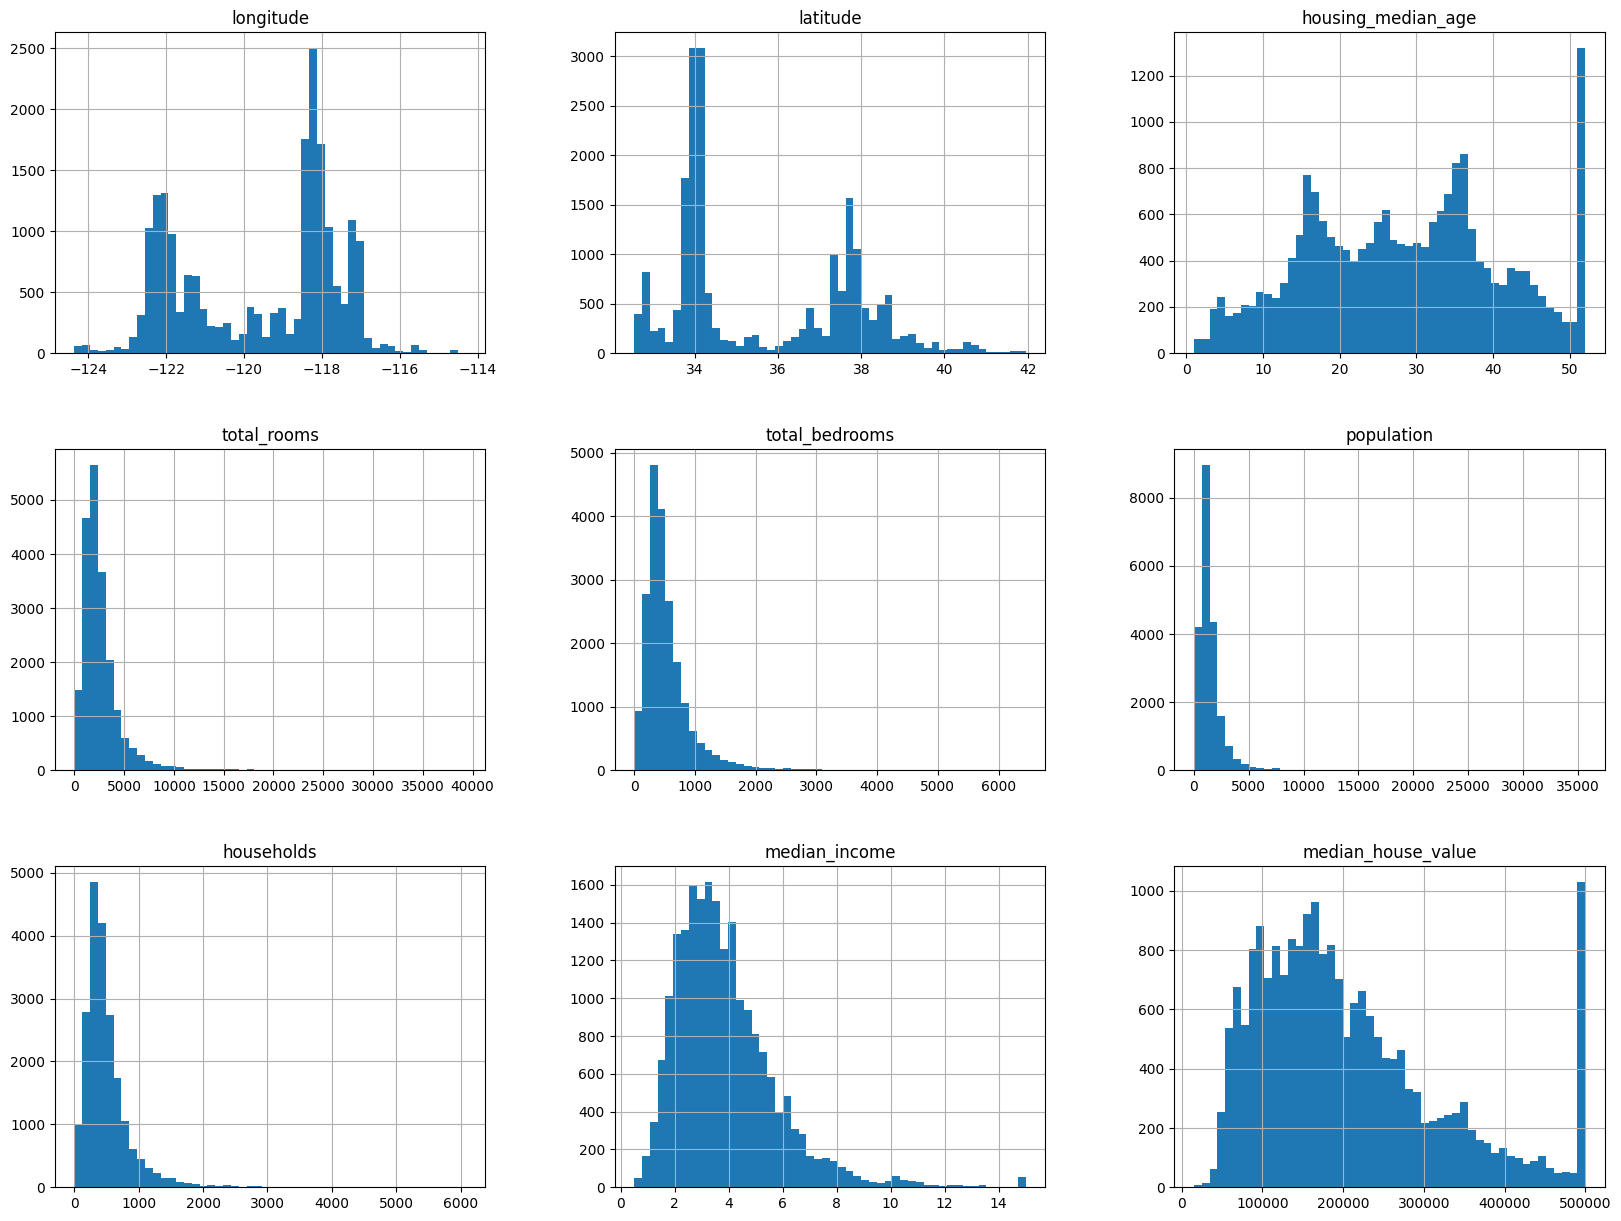

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')

housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [9]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print('TrainSet Length:', len(train_set))
print('TestSet Length:', len(test_set))

TrainSet Length: 16512
TestSet Length: 4128


In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print('TrainSet Length:', len(train_set))
print('TestSet Length:', len(test_set))

TrainSet Length: 16512
TestSet Length: 4128


In [12]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1,2,3,4,5])
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<AxesSubplot:>

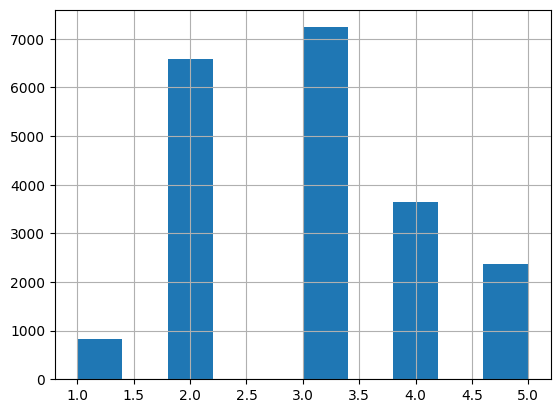

In [13]:
housing['income_cat'].hist()

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
overall_income_categories = housing['income_cat'].value_counts() / len(housing)
strat_income_categories = strat_train_set['income_cat'].value_counts() / len(strat_train_set)
shuffle_income_categories = train_set['income_cat'].value_counts() / len(train_set)
strat_error = (abs(overall_income_categories - strat_income_categories) / overall_income_categories) * 100
shuffle_error = (abs(overall_income_categories - shuffle_income_categories) / overall_income_categories) * 100

In [16]:
income_categories_df = pd.DataFrame({
    'Dataset': overall_income_categories,
    'Stratified': strat_income_categories,
    'Random Shuffle': shuffle_income_categories,
    'Stratified Error %': strat_error,
    'Random Shuffle Error %': shuffle_error
})
income_categories_df

,Dataset,Stratified,Random Shuffle,Stratified Error %,Random Shuffle Error %
3,0.350581,0.350594,0.348595,0.003455,0.566611
2,0.318847,0.318859,0.317466,0.003799,0.433065
4,0.176308,0.176296,0.178537,0.006870,1.264084
5,0.114438,0.114402,0.115673,0.031753,1.079594
1,0.039826,0.039850,0.039729,0.060827,0.243309


In [17]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

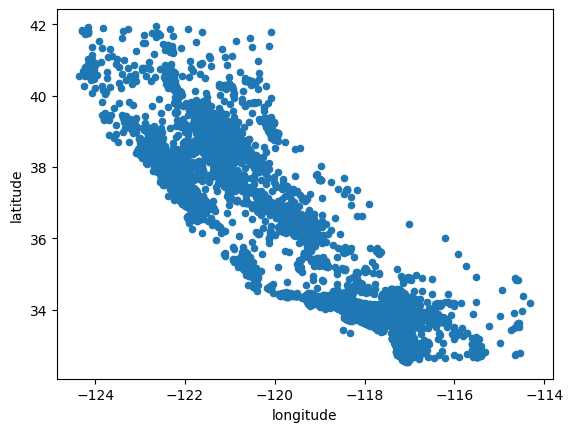

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

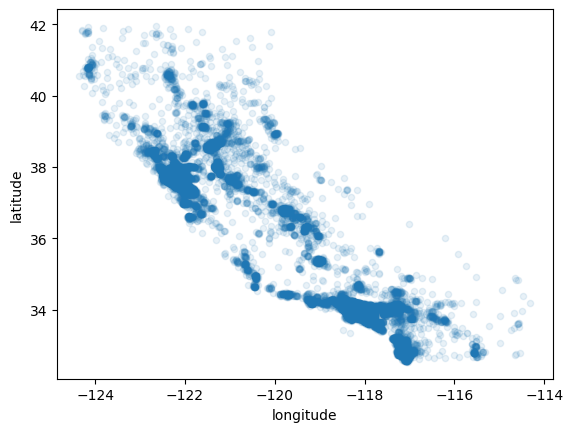

In [19]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

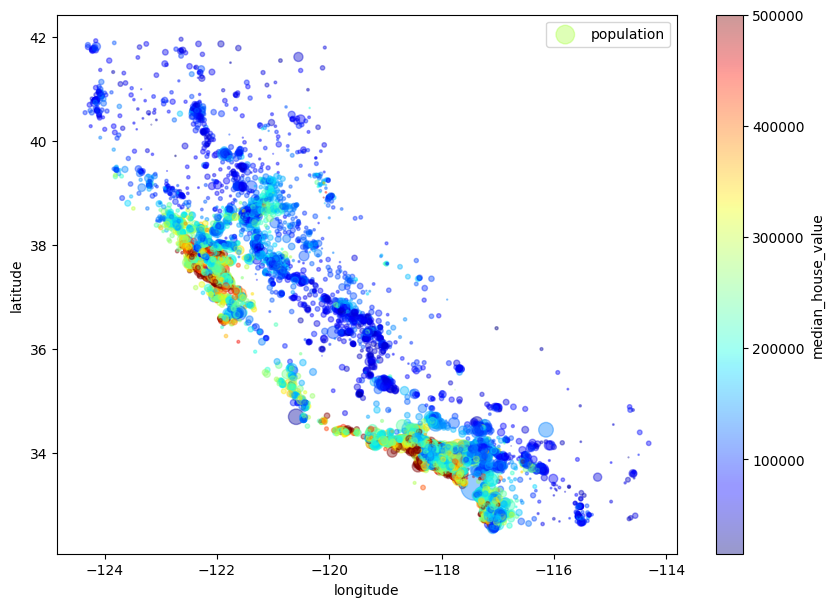

In [20]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='population', figsize=(10,7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [21]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

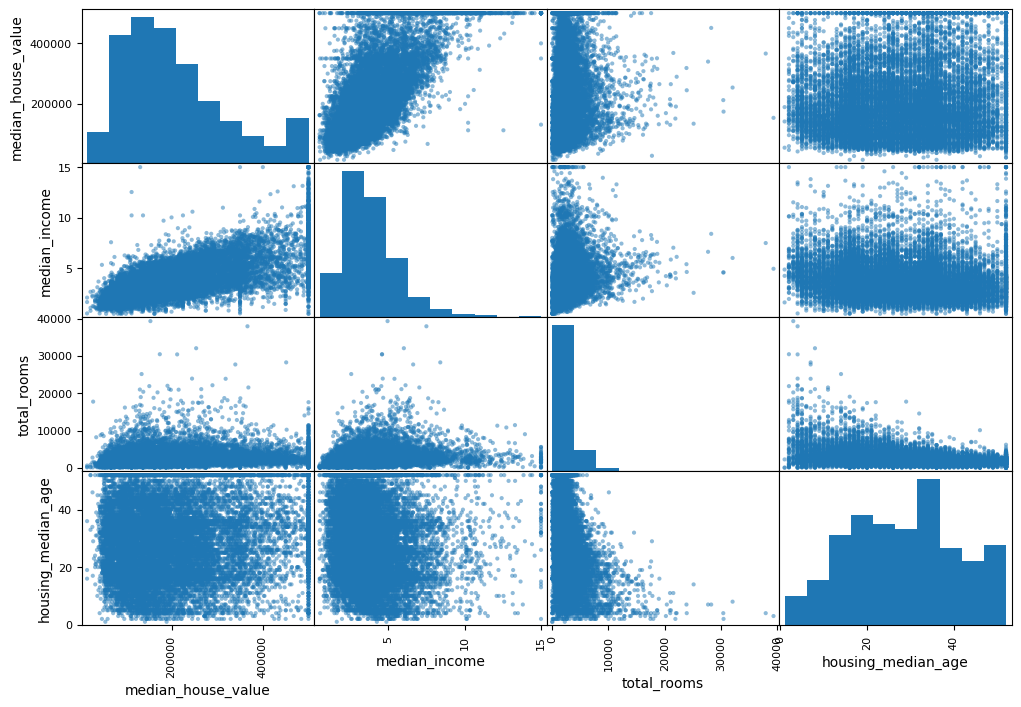

In [22]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

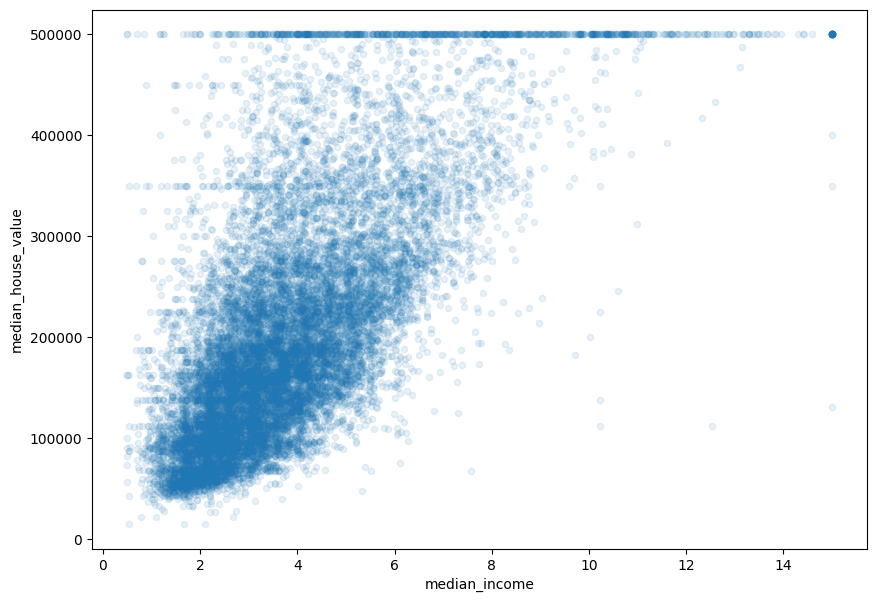

In [23]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(10,7))

In [24]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [25]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [26]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

The Column `total_bedrooms` has null values, to get rid of those values we can use the median of the existing values.

In [27]:
housing[housing['total_bedrooms'].isna()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,3
...,...,...,...,...,...,...,...,...,...,...
3376,-118.28,34.25,29.0,2559.0,NaN,1886.0,769.0,2.6036,<1H OCEAN,2
4691,-118.37,34.07,50.0,2519.0,NaN,1117.0,516.0,4.3667,<1H OCEAN,3
6052,-117.76,34.04,34.0,1914.0,NaN,1564.0,328.0,2.8347,INLAND,2
17198,-119.75,34.45,6.0,2864.0,NaN,1404.0,603.0,5.5073,NEAR OCEAN,4


Now we check if `total_bedrooms` columns doesn't have null values.

In [32]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)
housing[housing['total_bedrooms'].isna()].empty

True

#### Scikit-Learn Inputer
Using Scikit-Learn inputer class we can fill the dataset missing values.

In [33]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

Let's drop the categorical attributes to prevent `inputer` errors.

In [34]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [35]:
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [39]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [43]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr[housing_tr['total_bedrooms'].isna()].empty

True

#### Text and Categorical Attributes

We can use the class `OrdinalEncoder` to convert the categorical value `ocean_proximity` to
a numeric value. The problem with this encoding strategy is that some algorithms could learn

In [51]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [52]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [53]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [54]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [55]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_idx, bedrooms_idx, population_idx, households_idx = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pass

#### Transformation Pipelines

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

NameError: name 'Sim' is not defined